In [2]:
#import libraries

import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier



#import data
df = pd.read_csv('oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [4]:
{col:[df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}']for col in df.columns if df[col].isnull().any()}

{'SES': [19, '% 5.094'], 'MMSE': [2, '% 0.536']}

## Data Handling

<AxesSubplot:>

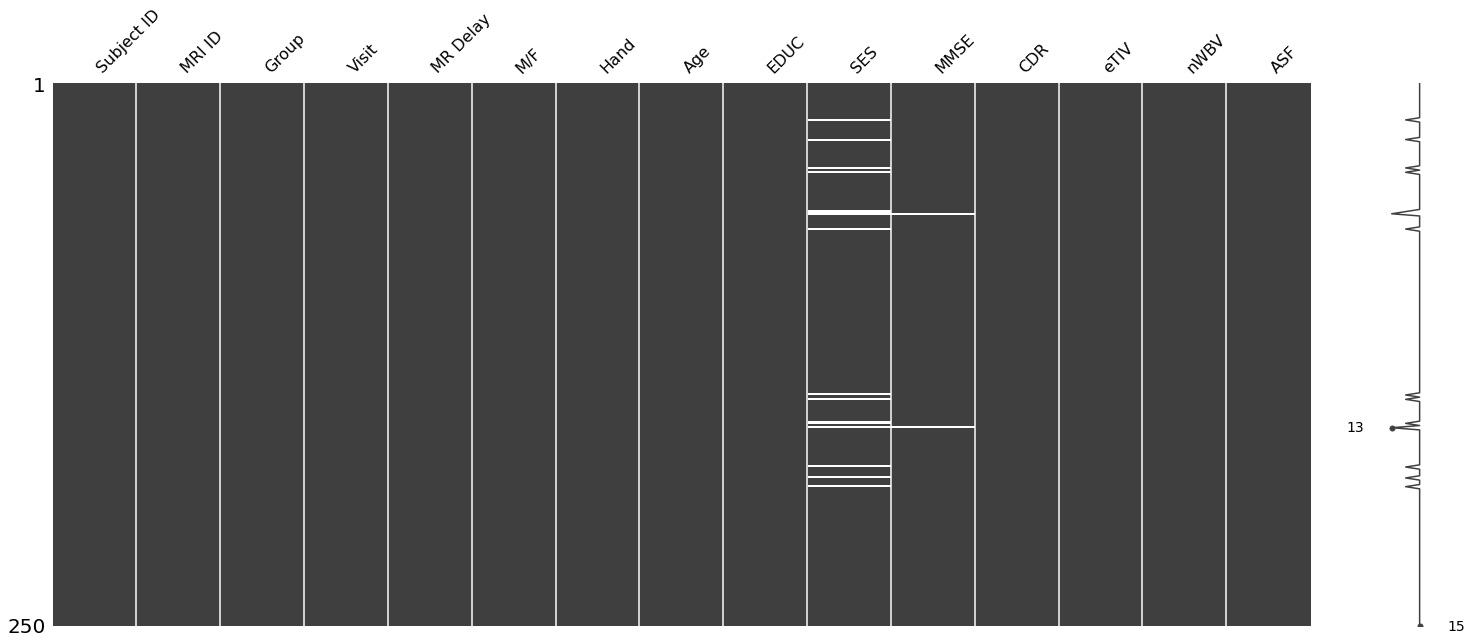

In [5]:
#missing info

%matplotlib inline
msno.matrix(df.sample(250))

In [6]:
df.describe().round(2)

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.00,373.00,373.00,373.00,354.00,371.00,373.00,373.00,373.00,373.00
mean,1.88,595.10,77.01,14.60,2.46,27.34,0.29,1488.13,0.73,1.20
std,0.92,635.49,7.64,2.88,1.13,3.68,0.37,176.14,0.04,0.14
min,1.00,0.00,60.00,6.00,1.00,4.00,0.00,1106.00,0.64,0.88
25%,1.00,0.00,71.00,12.00,2.00,27.00,0.00,1357.00,0.70,1.10
50%,2.00,552.00,77.00,15.00,2.00,29.00,0.00,1470.00,0.73,1.19
75%,2.00,873.00,82.00,16.00,3.00,30.00,0.50,1597.00,0.76,1.29
max,5.00,2639.00,98.00,23.00,5.00,30.00,2.00,2004.00,0.84,1.59


In [7]:
#relpace NaN of SES with mean

mean_SES = df['SES'].mean().round(2)
df['SES'].fillna(value=mean_SES, inplace=True)

In [8]:
# replace NaN of MMSE with mode

df['MMSE'].fillna(df['MMSE'].mode()[0], inplace=True)

<AxesSubplot:>

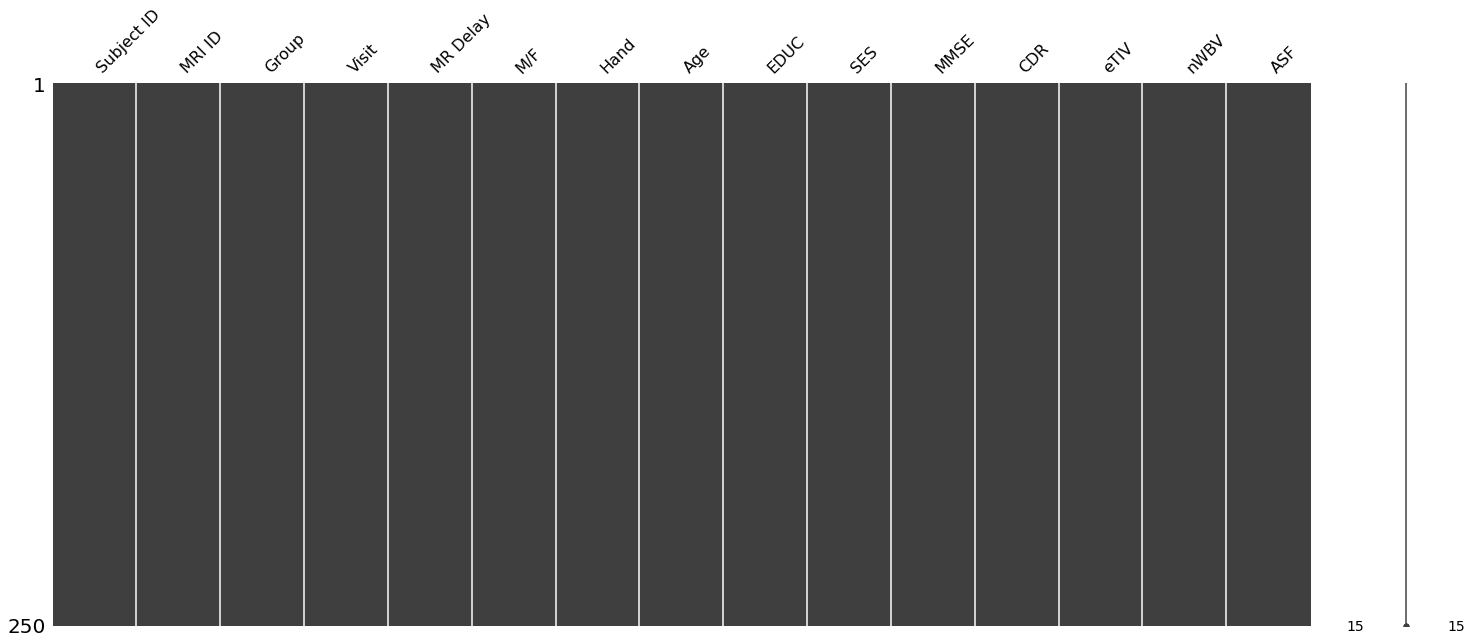

In [9]:
msno.matrix(df.sample(250))

In [10]:
#replace Converted with Demented

df['Group'].replace(['Converted'],['Demented'],inplace = True)

#replace M/F with [F,M] = [0,1]

df['M/F'].replace(['F','M'],[0,1], inplace = True)

#replace Group ['Demented','Nondemented'] = [1,0]
df['Group'].replace(['Demented','Nondemented'],[1,0], inplace = True)

In [11]:
# droping Hand as it does not play significant role in detemining AD or non-AD groups

df.drop(columns = ['Hand'],inplace = True)

In [12]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0,1,0,1,87,14,2.00,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,1,88,14,2.00,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,1,75,12,2.46,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,1,76,12,2.46,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,1,80,12,2.46,22.0,0.5,1698,0.701,1.034


# Correlation Matrix

Correlation is a measure that determines the degree to which the features are associated with each other, more specifically, the target variable (Alhaj et al., 2016). It can be positive or negative. A positive correlation means that if the single value of feature increases, the target variable’s value increases too, while the negative correlation indicates that if the particular value of feature increases, it results into the decrement of the target variable’s value. 

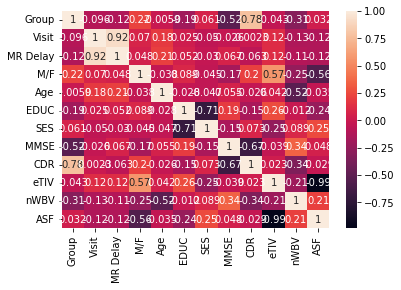

In [13]:
# Correlation matrix
columns_of_interest = ['Group', 'Visit','MR Delay', 'M/F',
                       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
corr_matrix = df[columns_of_interest].corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

The lighter shades represent positive correlation while darker shades signify a negative correlation.
From the figure, it can be seen that Visit and MR Delay are strongly correlated. However, we drop this feature too in our model building as it plays no role in determining the class of AD or non-AD group.

In [14]:
# also dropping Subject ID and MRI ID since they are irrelevant for our prediction model

df.drop(columns = ['Visit','MR Delay','Subject ID','MRI ID'], inplace  = True)

In [15]:
df

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.00,27.0,0.0,1987,0.696,0.883
1,0,1,88,14,2.00,30.0,0.0,2004,0.681,0.876
2,1,1,75,12,2.46,23.0,0.5,1678,0.736,1.046
3,1,1,76,12,2.46,28.0,0.5,1738,0.713,1.010
4,1,1,80,12,2.46,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...
368,1,1,82,16,1.00,28.0,0.5,1693,0.694,1.037
369,1,1,86,16,1.00,26.0,0.5,1688,0.675,1.040
370,0,0,61,13,2.00,30.0,0.0,1319,0.801,1.331
371,0,0,63,13,2.00,30.0,0.0,1327,0.796,1.323


## Data Prep

In [16]:
X = df.drop(columns = ['Group'])
y = df['Group']

## Feature Selection - f_classif() - ANOVA

In [17]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X,y)
X_fs = fs.transform(X)

In [18]:
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 19.258865
Feature 1: 0.013094
Feature 2: 14.363340
Feature 3: 1.370910
Feature 4: 136.501703
Feature 5: 569.099148
Feature 6: 0.677661
Feature 7: 39.823724
Feature 8: 0.392165


The result of this feature selection method supports CDR with the highest score = 569.099148 ,however, we dropped the CDR feature in our study before building of the ML model because CDR is a rating factor which may result in the less accurate models.CDR is a dementia rating factor which is categorized into ratings namely: 0, 0.5, 1, and 2, which does not aid in a model building but rather it is helpful prior to the model building phase, during the division of Group of demented and non-demented patients.

In our dataset most of CDR = 0.5, which according to studies it showed that the profiles of ABC-DS scores for individuals with a CDR of 0.5 were heterogeneous, and there were three subgroups among the individuals with CDR 0.5. This result suggested that a global CDR of 0.5 might not be an accurate criterion to specify individuals with MCI.

In [19]:
fs.pvalues_

array([1.48986928e-05, 9.08958275e-01, 1.75816853e-04, 2.42407035e-01,
       4.56251458e-27, 6.61217054e-77, 4.10922306e-01, 7.92931004e-10,
       5.31548820e-01])

In [20]:
alpha = 0.05
significant_features = X.columns[fs.pvalues_ < alpha]
significant_features

Index(['M/F', 'EDUC', 'MMSE', 'CDR', 'nWBV'], dtype='object')

If a feature has a high F-statistic score and a low p-value, it suggests that the feature is relevant for discriminating between different classes and is statistically significant.
If a feature has a low F-statistic score and a high p-value, it may not be a strong discriminator between classes, and the relationship might not be statistically significant.

According to research, it show that higher SES persons can expect to live significantly more years of life without dementia and that the period of life with dementia is compressed compared to less advantaged persons.

The results also underscore that importance of cumulative exposure, showing that adults from disadvantaged childhoods who achieve high education levels often have dementia experiences that are similar to or better than those of adults from advantaged childhoods who achieved low education levels.
--> Socioeconomic status across the life course and dementia-status life expectancy among older Americans
--> Hyungmin Cha a 1, Mateo P. Farina b 1, Mark D. Hayward a
--> https://www.sciencedirect.com/science/article/pii/S2352827321001968

Therefore we will take the significant features as ['M/F', 'EDUC', 'SES', 'MMSE', 'CDR', 'nWBV']

In [21]:
chi_scores = chi2(X, y)

In [22]:
chi_scores

(array([1.05113260e+01, 9.95332293e-03, 7.85813024e+00, 6.79245809e-01,
        4.94897902e+01, 1.08610650e+02, 1.41403656e+01, 6.81601493e-02,
        6.26585062e-03]),
 array([1.18645085e-03, 9.20529830e-01, 5.05926846e-03, 4.09846548e-01,
        1.99406792e-12, 1.97510588e-25, 1.69663753e-04, 7.94034680e-01,
        9.36907646e-01]))

<AxesSubplot:>

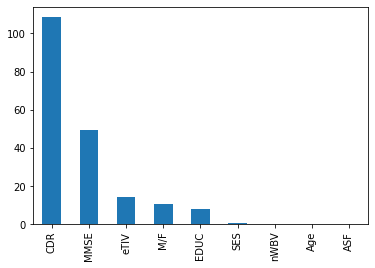

In [23]:
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

<AxesSubplot:>

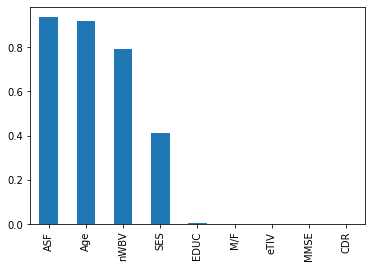

In [24]:
p_values = pd.Series(chi_scores[1], index=X.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

Low p-value might indicate that there is a significant association between two categorical variables.
High chi-squared statistic may indicate that there is a significant association between two categorical variables.

Therefore, from the chi^2 test we know that the significant features are ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

In [25]:
# dropping CDR
df.drop(columns = ['CDR'],inplace = True)

# Data Visualization

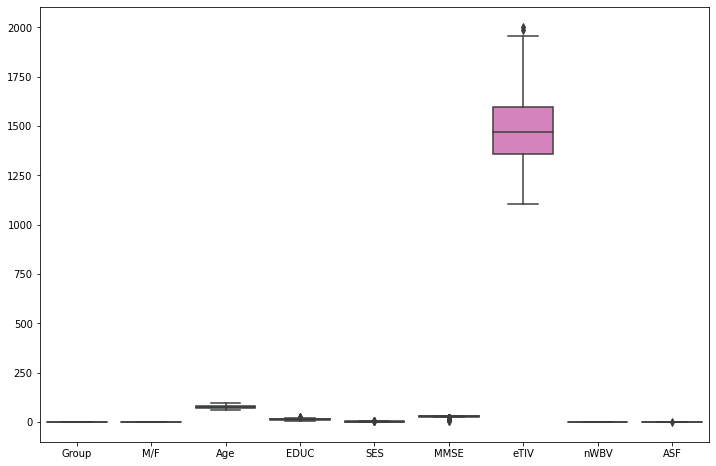

In [26]:
# Outliers
plt.figure(figsize=(12, 8))
sn.boxplot(data=df)
plt.show()

The columns ['Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF'] exhibit outliers while the rest of the columnsare outlier free

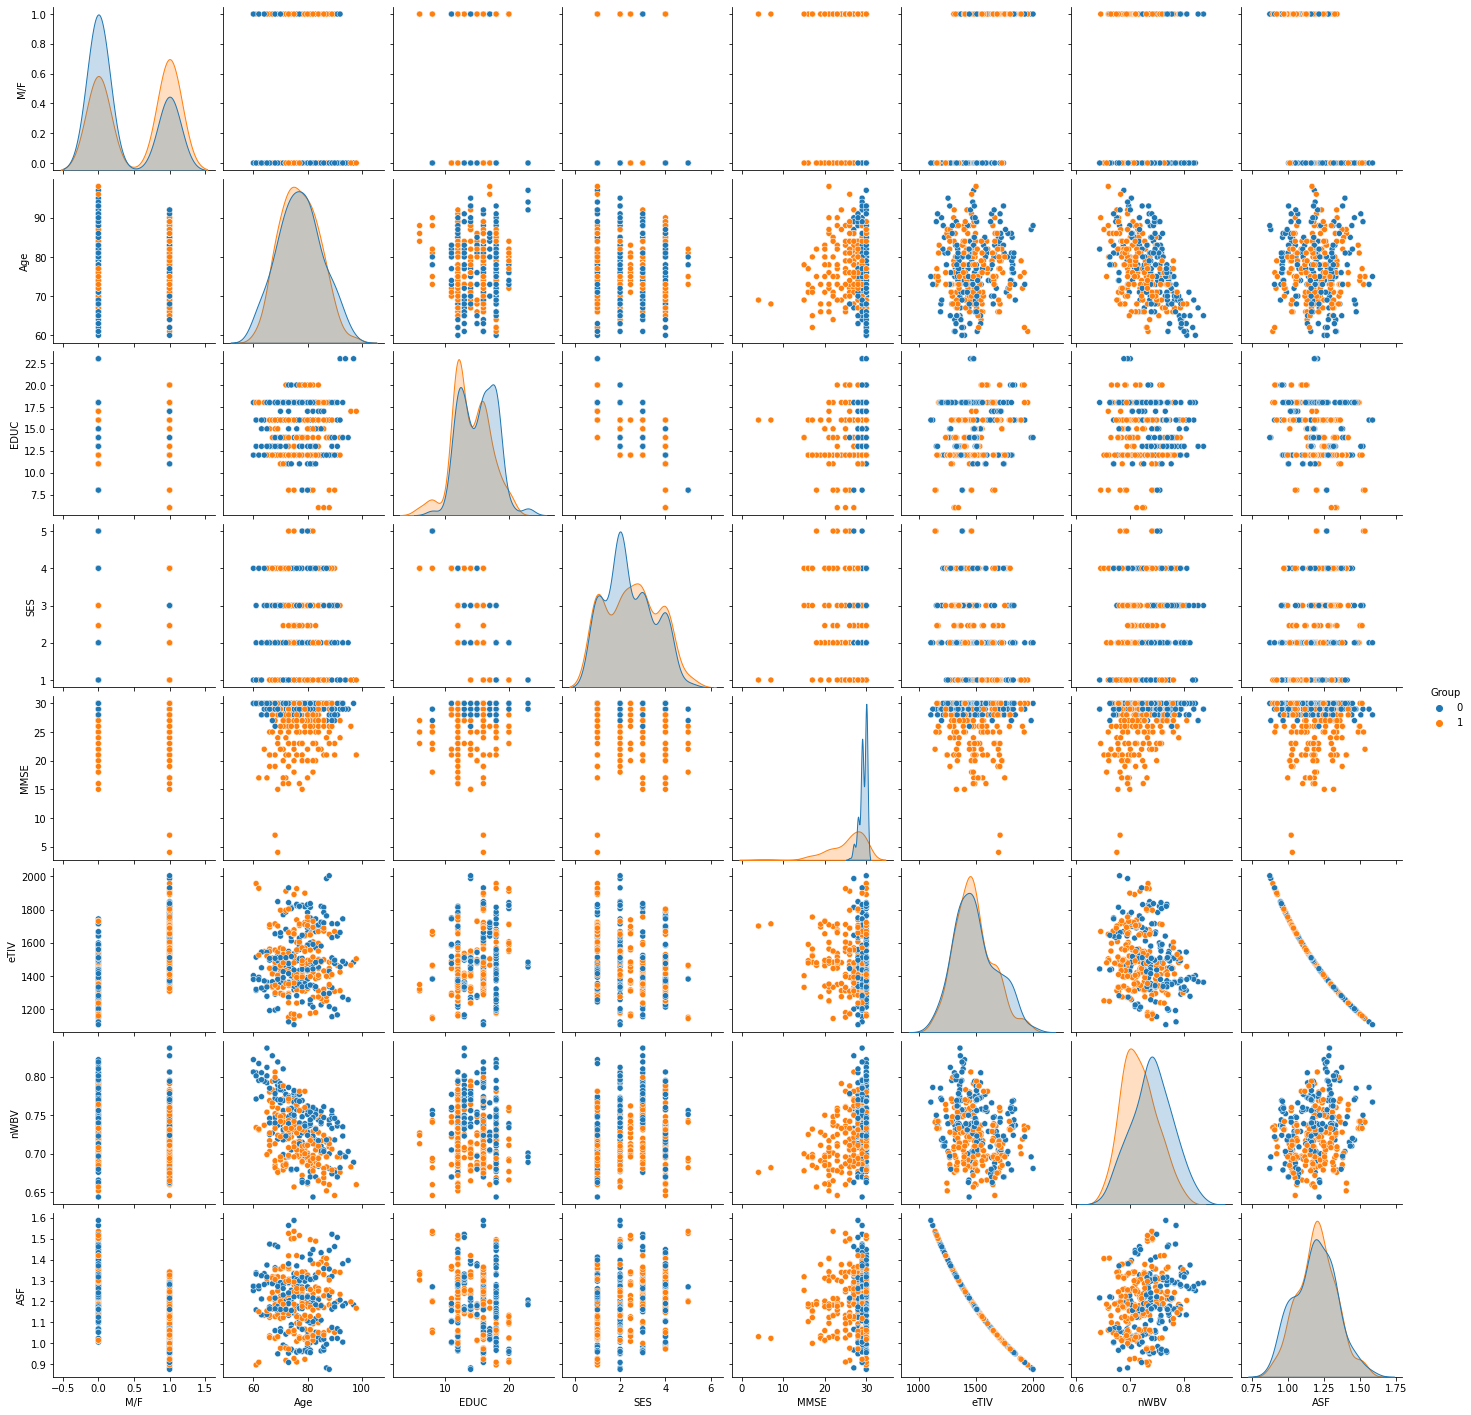

In [27]:
# Skewness

sn.pairplot(df, hue = 'Group')

The pairplot of the data gives us the insight that most of the features are normally distributed except MMSE, which is heavily left-skewed.

# Data Transformation

In [29]:
df

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,1,87,14,2.00,27.0,1987,0.696,0.883
1,0,1,88,14,2.00,30.0,2004,0.681,0.876
2,1,1,75,12,2.46,23.0,1678,0.736,1.046
3,1,1,76,12,2.46,28.0,1738,0.713,1.010
4,1,1,80,12,2.46,22.0,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...
368,1,1,82,16,1.00,28.0,1693,0.694,1.037
369,1,1,86,16,1.00,26.0,1688,0.675,1.040
370,0,0,61,13,2.00,30.0,1319,0.801,1.331
371,0,0,63,13,2.00,30.0,1327,0.796,1.323


In [30]:
# Standardization

X_1 = X[X.columns]

scaler = StandardScaler()
X_1[X_1.columns] = scaler.fit_transform(X_1[X_1.columns])

In [31]:
X_1

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1.153798,1.308738,-0.208132,-0.417364,-0.097064,-0.777653,2.836059,-0.905169,-2.265742
1,1.153798,1.439787,-0.208132,-0.417364,0.719588,-0.777653,2.932703,-1.309643,-2.316501
2,1.153798,-0.263856,-0.904394,-0.000389,-1.185934,0.559050,1.079409,0.173429,-1.083784
3,1.153798,-0.132806,-0.904394,-0.000389,0.175153,0.559050,1.420506,-0.446765,-1.344830
4,1.153798,0.391392,-0.904394,-0.000389,-1.458152,0.559050,1.193108,-0.770344,-1.170800
...,...,...,...,...,...,...,...,...,...
368,1.153798,0.653491,0.488130,-1.323831,0.175153,0.559050,1.164683,-0.959099,-1.149046
369,1.153798,1.177688,0.488130,-1.323831,-0.369282,0.559050,1.136259,-1.471432,-1.127292
370,-0.866703,-2.098548,-0.556263,-0.417364,0.719588,-0.777653,-0.961488,1.926149,0.982830
371,-0.866703,-1.836449,-0.556263,-0.417364,0.719588,-0.777653,-0.916009,1.791325,0.924820


In [32]:
X

,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,87,14,2.00,27.0,0.0,1987,0.696,0.883
1,1,88,14,2.00,30.0,0.0,2004,0.681,0.876
2,1,75,12,2.46,23.0,0.5,1678,0.736,1.046
3,1,76,12,2.46,28.0,0.5,1738,0.713,1.010
4,1,80,12,2.46,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...
368,1,82,16,1.00,28.0,0.5,1693,0.694,1.037
369,1,86,16,1.00,26.0,0.5,1688,0.675,1.040
370,0,61,13,2.00,30.0,0.0,1319,0.801,1.331
371,0,63,13,2.00,30.0,0.0,1327,0.796,1.323


# Data Segregation

In [33]:
# spliting data into train, test, and validation data

# Splitting data into Train Set (TR) and Test Set (TS)
X_train, X_temp, y_train, y_temp = train_test_split(X_1, y, test_size=0.3, random_state=42)

# Further split TR into Train Set (TR_train) and Validation Set (VS)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 1. Decision Tree

In [34]:


# Step 1: Model Training on Train Set (TR)
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth = 6)
dt_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred = dt_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Validation Set Accuracy:", accuracy_val)

training_predictions = dt_classifier.predict(X_train)
training_accuracy = accuracy_score(y_train, training_predictions)
print("Training Set Accuracy:", training_accuracy)

# Step 3: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Calculate the CV error (average accuracy)
cv_error = 1 - cv_scores.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error)

# Step 4: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for Decision Tree
param_grid = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# Create GridSearchCV instance
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_dt_model = grid_search.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best = best_dt_model.predict(X_val)
accuracy_val_best = accuracy_score(y_val, y_val_pred_best)
print("Best Model Validation Set Accuracy:", accuracy_val_best)

Validation Set Accuracy: 0.9464285714285714
Training Set Accuracy: 0.9846743295019157
Cross-Validation Scores: [0.86792453 0.94230769 0.96153846 0.94230769 0.96153846]
Mean CV Accuracy: 0.9351233671988389
Cross-Validation Error: 0.06487663280116107
Best Model Validation Set Accuracy: 0.9107142857142857


# 2. Random Forest

In [35]:


# Step 1: Model Training (Random Forest)
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth = 7)
rf_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_rf = rf_classifier.predict(X_val)
accuracy_val_rf = accuracy_score(y_val, y_val_pred_rf)
print("Validation Set Accuracy:", accuracy_val_rf)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_rf = rf_classifier.predict(X_train)
training_accuracy_rf = accuracy_score(y_train, training_predictions_rf)
print("Training Set Accuracy:", training_accuracy_rf)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)

cv_scores_rf = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_rf)
print("Mean CV Accuracy:", cv_scores_rf.mean())

# Calculate the CV error (average accuracy)
cv_error_rf = 1 - cv_scores_rf.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_rf)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for Random Forest
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5, 10]}

# Create GridSearchCV instance
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_rf.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_rf = best_rf_model.predict(X_val)
accuracy_val_best_rf = accuracy_score(y_val, y_val_pred_best_rf)
print("Best Model Validation Set Accuracy:", accuracy_val_best_rf)

Validation Set Accuracy: 0.9821428571428571
Training Set Accuracy: 0.9885057471264368
Cross-Validation Scores: [0.9245283  0.96153846 1.         0.94230769 0.96153846]
Mean CV Accuracy: 0.9579825834542817
Cross-Validation Error: 0.042017416545718334
Best Model Validation Set Accuracy: 0.9821428571428571


# 3. Gradient Booster

In [36]:


# Step 1: Model Training (Gradient Boosted Model)
gbm_classifier = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth = 2)
gbm_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_gbm = gbm_classifier.predict(X_val)
accuracy_val_gbm = accuracy_score(y_val, y_val_pred_gbm)
print("Validation Set Accuracy:", accuracy_val_gbm)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_gbm = gbm_classifier.predict(X_train)
training_accuracy_gbm = accuracy_score(y_train, training_predictions_gbm)
print("Training Set Accuracy:", training_accuracy_gbm)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_gbm = cross_val_score(gbm_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_gbm)
print("Mean CV Accuracy:", cv_scores_gbm.mean())

# Calculate the CV error (average accuracy)
cv_error_gbm = 1 - cv_scores_gbm.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_gbm)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for Gradient Boosted Model
param_grid_gbm = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}

# Create GridSearchCV instance
grid_search_gbm = GridSearchCV(estimator=gbm_classifier, param_grid=param_grid_gbm, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_gbm.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_gbm_model = grid_search_gbm.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_gbm = best_gbm_model.predict(X_val)
accuracy_val_best_gbm = accuracy_score(y_val, y_val_pred_best_gbm)
print("Best Model Validation Set Accuracy:", accuracy_val_best_gbm)


Validation Set Accuracy: 0.9642857142857143
Training Set Accuracy: 0.9770114942528736
Cross-Validation Scores: [0.9245283  0.96153846 1.         0.96153846 0.94230769]
Mean CV Accuracy: 0.9579825834542817
Cross-Validation Error: 0.042017416545718334
Best Model Validation Set Accuracy: 0.9285714285714286


# 4. Gaussian Naive Bayes

In [37]:


# Step 1: Model Training (Gaussian Naive Bayes)
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_gnb = gnb_classifier.predict(X_val)
accuracy_val_gnb = accuracy_score(y_val, y_val_pred_gnb)
print("Validation Set Accuracy:", accuracy_val_gnb)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_gnb = gnb_classifier.predict(X_train)
training_accuracy_gnb = accuracy_score(y_train, training_predictions_gnb)
print("Training Set Accuracy:", training_accuracy_gnb)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_gnb = cross_val_score(gnb_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_gnb)
print("Mean CV Accuracy:", cv_scores_gnb.mean())

# Calculate the CV error (average accuracy)
cv_error_gnb = 1 - cv_scores_gnb.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_gnb)


Validation Set Accuracy: 0.9285714285714286
Training Set Accuracy: 0.9616858237547893
Cross-Validation Scores: [0.94339623 0.96153846 1.         0.94230769 0.96153846]
Mean CV Accuracy: 0.9617561683599419
Cross-Validation Error: 0.03824383164005807


# 5. Linear SVC

In [38]:


# Step 1: Model Training
linear_svc_classifier = LinearSVC(random_state=42, max_iter = 1000000,dual=False)
linear_svc_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_linear_svc = linear_svc_classifier.predict(X_val)
accuracy_val_linear_svc = accuracy_score(y_val, y_val_pred_linear_svc)
print("Validation Set Accuracy:", accuracy_val_linear_svc)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_linear_svc = linear_svc_classifier.predict(X_train)
training_accuracy_linear_svc = accuracy_score(y_train, training_predictions_linear_svc)
print("Training Set Accuracy:", training_accuracy_linear_svc)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_linear_svc = cross_val_score(linear_svc_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_linear_svc)
print("Mean CV Accuracy:", cv_scores_linear_svc.mean())

# Calculate the CV error (average accuracy)
cv_error_linear_svc = 1 - cv_scores_linear_svc.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_linear_svc)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for LinearSVC
param_grid_linear_svc = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create GridSearchCV instance
grid_search_linear_svc = GridSearchCV(estimator=linear_svc_classifier, param_grid=param_grid_linear_svc, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_linear_svc.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_linear_svc_model = grid_search_linear_svc.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_linear_svc = best_linear_svc_model.predict(X_val)
accuracy_val_best_linear_svc = accuracy_score(y_val, y_val_pred_best_linear_svc)
print("Best Model Validation Set Accuracy:", accuracy_val_best_linear_svc)


Validation Set Accuracy: 0.9464285714285714
Training Set Accuracy: 0.9578544061302682
Cross-Validation Scores: [0.9245283  0.96153846 1.         0.94230769 0.96153846]
Mean CV Accuracy: 0.9579825834542817
Cross-Validation Error: 0.042017416545718334
Best Model Validation Set Accuracy: 0.9464285714285714


# 6. Ada Boost Classifier

In [39]:


# Step 1: Model Training
adaboost_classifier = AdaBoostClassifier(random_state=42, algorithm = 'SAMME')
adaboost_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_adaboost = adaboost_classifier.predict(X_val)
accuracy_val_adaboost = accuracy_score(y_val, y_val_pred_adaboost)
print("Validation Set Accuracy:", accuracy_val_adaboost)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_adaboost = adaboost_classifier.predict(X_train)
training_accuracy_adaboost = accuracy_score(y_train, training_predictions_adaboost)
print("Training Set Accuracy:", training_accuracy_adaboost)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_adaboost = cross_val_score(adaboost_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_adaboost)
print("Mean CV Accuracy:", cv_scores_adaboost.mean())

# Calculate the CV error (average accuracy)
cv_error_adaboost = 1 - cv_scores_adaboost.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_adaboost)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for AdaBoostClassifier
param_grid_adaboost = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.2]}

# Create GridSearchCV instance
grid_search_adaboost = GridSearchCV(estimator=adaboost_classifier, param_grid=param_grid_adaboost, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_adaboost.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_adaboost_model = grid_search_adaboost.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_adaboost = best_adaboost_model.predict(X_val)
accuracy_val_best_adaboost = accuracy_score(y_val, y_val_pred_best_adaboost)
print("Best Model Validation Set Accuracy:", accuracy_val_best_adaboost)


Validation Set Accuracy: 0.9642857142857143
Training Set Accuracy: 0.9655172413793104
Cross-Validation Scores: [0.9245283  0.96153846 1.         0.94230769 0.96153846]
Mean CV Accuracy: 0.9579825834542817
Cross-Validation Error: 0.042017416545718334
Best Model Validation Set Accuracy: 0.9464285714285714


# 7. Passive Aggressive Classifier

In [40]:


# Step 1: Model Training
pa_classifier = PassiveAggressiveClassifier(random_state=42)
pa_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_pa = pa_classifier.predict(X_val)
accuracy_val_pa = accuracy_score(y_val, y_val_pred_pa)
print("Validation Set Accuracy:", accuracy_val_pa)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_pa = pa_classifier.predict(X_train)
training_accuracy_pa = accuracy_score(y_train, training_predictions_pa)
print("Training Set Accuracy:", training_accuracy_pa)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_pa = cross_val_score(pa_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_pa)
print("Mean CV Accuracy:", cv_scores_pa.mean())

# Calculate the CV error (average accuracy)
cv_error_pa = 1 - cv_scores_pa.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_pa)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for PassiveAggressiveClassifier
param_grid_pa = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [1000, 2000, 5000]}

# Create GridSearchCV instance
grid_search_pa = GridSearchCV(estimator=pa_classifier, param_grid=param_grid_pa, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_pa.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_pa_model = grid_search_pa.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_pa = best_pa_model.predict(X_val)
accuracy_val_best_pa = accuracy_score(y_val, y_val_pred_best_pa)
print("Best Model Validation Set Accuracy:", accuracy_val_best_pa)


Validation Set Accuracy: 0.9464285714285714
Training Set Accuracy: 0.9501915708812261
Cross-Validation Scores: [0.86792453 0.88461538 0.82692308 0.92307692 0.90384615]
Mean CV Accuracy: 0.881277213352685
Cross-Validation Error: 0.11872278664731495
Best Model Validation Set Accuracy: 0.9464285714285714


# 8. K- Nearest Neighbours

In [41]:


# Step 1: Model Training
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_knn = knn_classifier.predict(X_val)
accuracy_val_knn = accuracy_score(y_val, y_val_pred_knn)
print("Validation Set Accuracy:", accuracy_val_knn)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_knn = knn_classifier.predict(X_train)
training_accuracy_knn = accuracy_score(y_train, training_predictions_knn)
print("Training Set Accuracy:", training_accuracy_knn)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_knn = cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_knn)
print("Mean CV Accuracy:", cv_scores_knn.mean())

# Calculate the CV error (average accuracy)
cv_error_knn = 1 - cv_scores_knn.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_knn)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for KNeighborsClassifier
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

# Create GridSearchCV instance
grid_search_knn = GridSearchCV(estimator=knn_classifier, param_grid=param_grid_knn, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_knn.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_knn_model = grid_search_knn.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_knn = best_knn_model.predict(X_val)
accuracy_val_best_knn = accuracy_score(y_val, y_val_pred_best_knn)
print("Best Model Validation Set Accuracy:", accuracy_val_best_knn)


Validation Set Accuracy: 0.875
Training Set Accuracy: 0.9616858237547893
Cross-Validation Scores: [0.94339623 0.90384615 0.98076923 0.90384615 0.92307692]
Mean CV Accuracy: 0.9309869375907113
Cross-Validation Error: 0.06901306240928873
Best Model Validation Set Accuracy: 0.9285714285714286


# 9. Support Vector Classifier

In [42]:


# Step 1: Model Training
svc_classifier = SVC(random_state=42, probability=True, C=1.0, kernel='rbf', gamma='scale')
svc_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_svc = svc_classifier.predict(X_val)
accuracy_val_svc = accuracy_score(y_val, y_val_pred_svc)
print("Validation Set Accuracy:", accuracy_val_svc)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_svc = svc_classifier.predict(X_train)
training_accuracy_svc = accuracy_score(y_train, training_predictions_svc)
print("Training Set Accuracy:", training_accuracy_svc)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_svc = cross_val_score(svc_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_svc)
print("Mean CV Accuracy:", cv_scores_svc.mean())

# Calculate the CV error (average accuracy)
cv_error_svc = 1 - cv_scores_svc.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_svc)

# Step 5: Model Validation (Hyperparameter Tuning)
# Define a hyperparameter grid for SVC
param_grid_svc = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Create GridSearchCV instance
grid_search_svc = GridSearchCV(estimator=svc_classifier, param_grid=param_grid_svc, cv=3, scoring='accuracy')

# Fit the GridSearchCV on the entire training set (TR)
grid_search_svc.fit(X_train, y_train)

# Get the best model from hyperparameter tuning
best_svc_model = grid_search_svc.best_estimator_

# Evaluate the best model on the validation set (VS)
y_val_pred_best_svc = best_svc_model.predict(X_val)
accuracy_val_best_svc = accuracy_score(y_val, y_val_pred_best_svc)
print("Best Model Validation Set Accuracy:", accuracy_val_best_svc)


Validation Set Accuracy: 0.9464285714285714
Training Set Accuracy: 0.9578544061302682
Cross-Validation Scores: [0.9245283  0.96153846 1.         0.94230769 0.96153846]
Mean CV Accuracy: 0.9579825834542817
Cross-Validation Error: 0.042017416545718334
Best Model Validation Set Accuracy: 0.9464285714285714


# 10. Bernoulli Naive Bayes

In [43]:


# Step 1: Model Training
bernoulli_classifier = BernoulliNB()
bernoulli_classifier.fit(X_train, y_train)

# Step 2: Model Evaluation
# Evaluate the model on the validation set (VS)
y_val_pred_bernoulli = bernoulli_classifier.predict(X_val)
accuracy_val_bernoulli = accuracy_score(y_val, y_val_pred_bernoulli)
print("Validation Set Accuracy:", accuracy_val_bernoulli)

# Step 3: Training Set Accuracy
# Calculate training set accuracy using the score method or accuracy_score function
training_predictions_bernoulli = bernoulli_classifier.predict(X_train)
training_accuracy_bernoulli = accuracy_score(y_train, training_predictions_bernoulli)
print("Training Set Accuracy:", training_accuracy_bernoulli)

# Step 4: Cross-Validation
# Perform cross-validation on the entire training set (TR)
cv_scores_bernoulli = cross_val_score(bernoulli_classifier, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores_bernoulli)
print("Mean CV Accuracy:", cv_scores_bernoulli.mean())

# Calculate the CV error (average accuracy)
cv_error_bernoulli = 1 - cv_scores_bernoulli.mean()  # 1 - mean accuracy gives error
print("Cross-Validation Error:", cv_error_bernoulli)

Validation Set Accuracy: 0.9464285714285714
Training Set Accuracy: 0.9425287356321839
Cross-Validation Scores: [0.90566038 0.92307692 0.98076923 0.94230769 0.96153846]
Mean CV Accuracy: 0.9426705370101598
Cross-Validation Error: 0.05732946298984021


# Model Prediction

In [44]:


# Model 1 - Decision Tree
y_test_pred_dt = dt_classifier.predict(X_test)
accuracy_test_dt = accuracy_score(y_test, y_test_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_test_pred_dt)
classification_rep_dt = classification_report(y_test, y_test_pred_dt)
auc_dt = roc_auc_score(y_test, dt_classifier.predict_proba(X_test)[:, 1])

# Model 2 - Random Forest
y_test_pred_rf = rf_classifier.predict(X_test)
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
classification_rep_rf = classification_report(y_test, y_test_pred_rf)
auc_rf = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

# Model 3 - Gradient Booster
y_test_pred_gbm = gbm_classifier.predict(X_test)
accuracy_test_gbm = accuracy_score(y_test, y_test_pred_gbm)
conf_matrix_gbm = confusion_matrix(y_test, y_test_pred_gbm)
classification_rep_gbm = classification_report(y_test, y_test_pred_gbm)
auc_gbm = roc_auc_score(y_test, gbm_classifier.predict_proba(X_test)[:, 1])

# Model 4 - Gaussian Naive Bayes
y_test_pred_gnb = gnb_classifier.predict(X_test)
accuracy_test_gnb = accuracy_score(y_test, y_test_pred_gnb)
conf_matrix_gnb = confusion_matrix(y_test, y_test_pred_gnb)
classification_rep_gnb = classification_report(y_test, y_test_pred_gnb)
auc_gnb = roc_auc_score(y_test, gnb_classifier.predict_proba(X_test)[:, 1])

# Model 5 - Linear SVC
y_test_pred_linear_svc = linear_svc_classifier.predict(X_test)
accuracy_test_linear_svc = accuracy_score(y_test, y_test_pred_linear_svc)
conf_matrix_linear_svc = confusion_matrix(y_test, y_test_pred_linear_svc)
classification_rep_linear_svc = classification_report(y_test, y_test_pred_linear_svc)
y_test_decision_linear_svc = linear_svc_classifier.decision_function(X_test)
auc_score_linear_svc = roc_auc_score(y_test, y_test_decision_linear_svc)

# Model 6 - Ada Boost Classifier
y_test_pred_adaboost = adaboost_classifier.predict(X_test)
accuracy_test_adaboost = accuracy_score(y_test, y_test_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_test, y_test_pred_adaboost)
classification_rep_adaboost = classification_report(y_test, y_test_pred_adaboost)
auc_adaboost = roc_auc_score(y_test, adaboost_classifier.predict_proba(X_test)[:, 1])

# Model 7 - Passive Aggressive Classifier
y_test_pred_pa = pa_classifier.predict(X_test)
accuracy_test_pa = accuracy_score(y_test, y_test_pred_pa)
conf_matrix_pa = confusion_matrix(y_test, y_test_pred_pa)
classification_rep_pa = classification_report(y_test, y_test_pred_pa)
y_test_decision_pa = pa_classifier.decision_function(X_test)
auc_score_pa = roc_auc_score(y_test, y_test_decision_pa)

# Model 8 - K Nearest Neighbours
y_test_pred_knn = knn_classifier.predict(X_test)
accuracy_test_knn = accuracy_score(y_test, y_test_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
classification_rep_knn = classification_report(y_test, y_test_pred_knn)
auc_knn = roc_auc_score(y_test, knn_classifier.predict_proba(X_test)[:, 1])

# Model 9 - Support Vector Classifier
y_test_pred_svc = svc_classifier.predict(X_test)
accuracy_test_svc = accuracy_score(y_test, y_test_pred_svc)
conf_matrix_svc = confusion_matrix(y_test, y_test_pred_svc)
classification_rep_svc = classification_report(y_test, y_test_pred_svc)
auc_svc = roc_auc_score(y_test, svc_classifier.predict_proba(X_test)[:, 1])

# Model 10 - Bernoulli Naive Bayes
y_test_pred_bernoulli = bernoulli_classifier.predict(X_test)
accuracy_test_bernoulli = accuracy_score(y_test, y_test_pred_bernoulli)
conf_matrix_bernoulli = confusion_matrix(y_test, y_test_pred_bernoulli)
classification_rep_bernoulli = classification_report(y_test, y_test_pred_bernoulli)
auc_bernoulli  = roc_auc_score(y_test, bernoulli_classifier.predict_proba(X_test)[:, 1])


# Display the results for Model 1
print('Results for Decision Tree:')
print(f'Test Set Accuracy: {accuracy_test_dt}')
print('Confusion Matrix:')
print(conf_matrix_dt)
print('Classification Report:')
print(classification_rep_dt)
print(f'AUC: {auc_dt}')

# Display the results for Model 2
print('Results for Random Forest:')
print(f'Test Set Accuracy: {accuracy_test_rf}')
print('Confusion Matrix:')
print(conf_matrix_rf)
print('Classification Report:')
print(classification_rep_rf)
print(f'AUC: {auc_rf}')

# Display the results for Model 3
print('Results for Gradient Booster:')
print(f'Test Set Accuracy: {accuracy_test_gbm}')
print('Confusion Matrix:')
print(conf_matrix_gbm)
print('Classification Report:')
print(classification_rep_gbm)
print(f'AUC: {auc_gbm}')

# Display the results for Model 4
print('Results for Gaussian Naive Bayes:')
print(f'Test Set Accuracy: {accuracy_test_gnb}')
print('Confusion Matrix:')
print(conf_matrix_gnb)
print('Classification Report:')
print(classification_rep_gnb)
print(f'AUC: {auc_gnb}')

# Display the results for Model 5
print('Results for Linear SVC:')
print(f'Test Set Accuracy: {accuracy_test_linear_svc}')
print('Confusion Matrix:')
print(conf_matrix_linear_svc)
print('Classification Report:')
print(classification_rep_linear_svc)
print(f'AUC: {auc_score_linear_svc}')

# Display the results for Model 6
print('Results for Ada Boost Classifier:')
print(f'Test Set Accuracy: {accuracy_test_adaboost}')
print('Confusion Matrix:')
print(conf_matrix_adaboost)
print('Classification Report:')
print(classification_rep_adaboost)
print(f'AUC: {auc_adaboost}')

# Display the results for Model 7
print('Results for Passive Aggressive Classifier:')
print(f'Test Set Accuracy: {accuracy_test_pa}')
print('Confusion Matrix:')
print(conf_matrix_pa)
print('Classification Report:')
print(classification_rep_pa)
print(f'AUC: {auc_score_pa}')

# Display the results for Model 8
print('Results for K Nearest Neighbours:')
print(f'Test Set Accuracy: {accuracy_test_knn}')
print('Confusion Matrix:')
print(conf_matrix_knn)
print('Classification Report:')
print(classification_rep_knn)
print(f'AUC: {auc_knn}')

# Display the results for Model 9
print('Results for Support Vector Classifier:')
print(f'Test Set Accuracy: {accuracy_test_svc}')
print('Confusion Matrix:')
print(conf_matrix_svc)
print('Classification Report:')
print(classification_rep_svc)
print(f'AUC: {auc_svc}')

# Display the results for Model 10
print('Results for Bernoulli Naive Bayes:')
print(f'Test Set Accuracy: {accuracy_test_bernoulli}')
print('Confusion Matrix:')
print(conf_matrix_bernoulli)
print('Classification Report:')
print(classification_rep_bernoulli)
print(f'AUC: {auc_bernoulli}')

Results for Decision Tree:
Test Set Accuracy: 0.8392857142857143
Confusion Matrix:
[[21  3]
 [ 6 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        24
           1       0.90      0.81      0.85        32

    accuracy                           0.84        56
   macro avg       0.84      0.84      0.84        56
weighted avg       0.85      0.84      0.84        56

AUC: 0.8535156250000001
Results for Random Forest:
Test Set Accuracy: 0.8928571428571429
Confusion Matrix:
[[23  1]
 [ 5 27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        24
           1       0.96      0.84      0.90        32

    accuracy                           0.89        56
   macro avg       0.89      0.90      0.89        56
weighted avg       0.90      0.89      0.89        56

AUC: 0.9231770833333334
Results for Gradient Booster:
Test Set Accuracy:

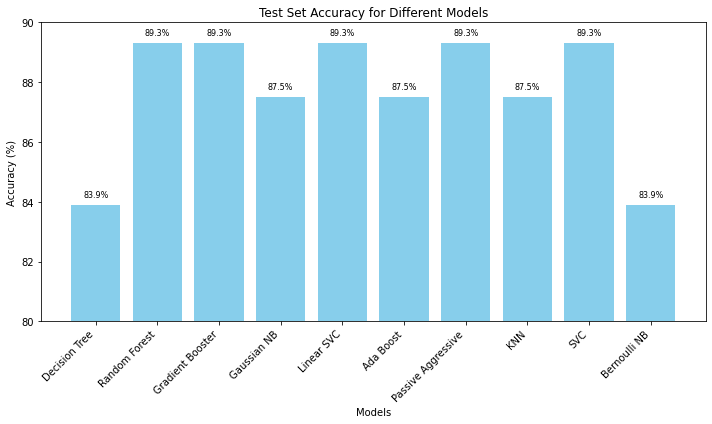

In [45]:

models = ['Decision Tree', 'Random Forest', 'Gradient Booster', 'Gaussian NB', 'Linear SVC', 'Ada Boost', 'Passive Aggressive', 'KNN', 'SVC', 'Bernoulli NB']
accuracies = [83.9, 89.3, 89.3, 87.5, 89.3, 87.5, 89.3, 87.5, 89.3, 83.9]

# Create a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Test Set Accuracy for Different Models')
plt.ylim(80, 90)  # Adjust the y-axis limits if needed
plt.xticks(rotation=45, ha='right')

# Display the accuracy values on top of the bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{acc}%', ha='center', va='bottom', fontsize=8)

# Show the plot
plt.tight_layout()
plt.show()


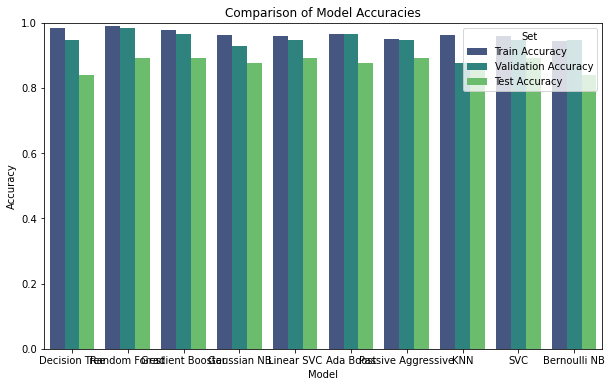

In [46]:
model_names = ['Decision Tree', 'Random Forest', 'Gradient Booster', 'Gaussian NB', 'Linear SVC', 'Ada Boost', 'Passive Aggressive', 'KNN', 'SVC', 'Bernoulli NB']
train_accuracies = [training_accuracy, training_accuracy_rf, training_accuracy_gbm, training_accuracy_gnb, training_accuracy_linear_svc, training_accuracy_adaboost, training_accuracy_pa, training_accuracy_knn, training_accuracy_svc, training_accuracy_bernoulli]  
val_accuracies = [accuracy_val, accuracy_val_rf, accuracy_val_gbm, accuracy_val_gnb, accuracy_val_linear_svc, accuracy_val_adaboost, accuracy_val_pa, accuracy_val_knn, accuracy_val_svc, accuracy_val_bernoulli ]
test_accuracies = [accuracy_test_dt, accuracy_test_rf, accuracy_test_gbm, accuracy_test_gnb, accuracy_test_linear_svc, accuracy_test_adaboost, accuracy_test_pa, accuracy_test_knn, accuracy_test_svc, accuracy_test_bernoulli] 

# Create a DataFrame for easy plotting
df1 = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': val_accuracies,
    'Test Accuracy': test_accuracies
})

# Melt the DataFrame for better visualization
df1_melted = pd.melt(df1, id_vars='Model', var_name='Set', value_name='Accuracy')

# Plot using seaborn
plt.figure(figsize=(10, 6))
sn.barplot(x='Model', y='Accuracy', hue='Set', data=df1_melted, palette='viridis')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)  # Set y-axis limits to match accuracy scale (0 to 1)
plt.ylabel('Accuracy')
plt.show()

In [47]:
# Calculate average accuracy across sets for each model
df1['Average Accuracy'] = df1[['Train Accuracy', 'Validation Accuracy', 'Test Accuracy']].mean(axis=1)

# Find the best model based on average accuracy
best_model = df1.loc[df1['Average Accuracy'].idxmax()]

print("Best Model:")
print(best_model)

Best Model:
Model                  Random Forest
Train Accuracy              0.988506
Validation Accuracy         0.982143
Test Accuracy               0.892857
Average Accuracy            0.954502
Name: 1, dtype: object


Comparing testing set accuracy, training set accuracy and validation set accuracy, Random Forest Model is found out to be the best model for the AD and non AD prediction

# Confusion Matrix for Random Forest (RF) Model

In [48]:
df['Group'].unique()

array([0, 1])

Confusion matrix, without normalization
[[23  1]
 [ 5 27]]
Normalized confusion matrix
[[0.95833333 0.04166667]
 [0.15625    0.84375   ]]


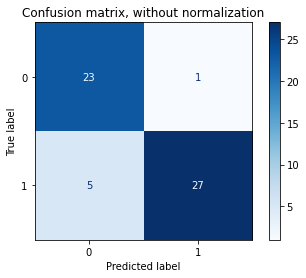

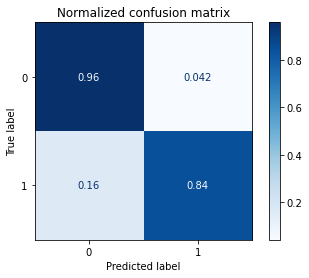

In [49]:
class_names = df['Group'].unique()
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        rf_classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Here,
True Positive (TP) = RF correctly predicted the demented rate, as 27 patients. 84% of the MRI cases have been detected to suffer from this disease.

True Negatives (TN): RF correctly predicted that 23 patients do not have dementia. 96% of the MRI cases have been detected that does not suffer from dementia.

False Positives (FP): RF incorrectly predicted that only 1 patient (only 4.2%) have dementia i.e. it falsely predicts positive. This is called “Type I error”.

False Negatives (FN): RF incorrectly predicted that only 5 patients (only 1.6%) don’t have dementia i.e. it falsely predicts negative. This is called “Type II error”.

In [50]:
from sklearn.metrics import precision_score, recall_score, f1_score

TN, FP, FN, TP = disp.confusion_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
classification_error = (FP + FN) / (TP + TN + FP + FN)

y_scores = rf_classifier.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_scores)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Classification Error: {classification_error:.2f}")
print(f"AUC Score: {auc_score:.2f}")

Accuracy: 0.90
Precision: 0.95
Recall: 0.84
F1 Score: 0.90
Classification Error: 0.10
AUC Score: 0.92


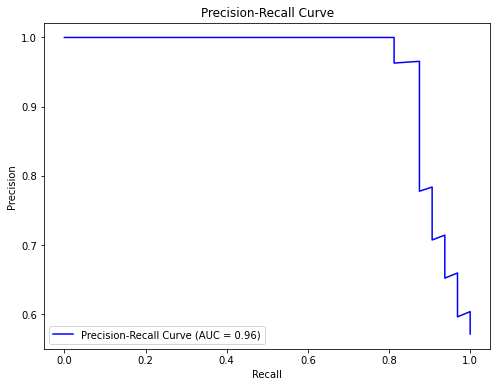

In [51]:
from sklearn.metrics import precision_recall_curve, auc

y_scores = rf_classifier.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

PR curve displays the relationship between precision and recall. We could easily note that precision falls at 96% while recall at 84%.  

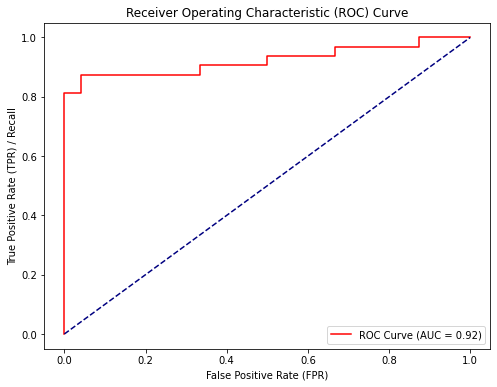

In [52]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


The area under the ROC curve is known as AUC. It can be seen from the above figure that the AUC score comes out to be almost equal to 92.0%. The same score is reported in model performance metrics. Thus, this score of AUC is a higher number that indicates RF classifier performs much better in classifying the AD and non-AD patients.